In [69]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

In [70]:
#dataset reading code is used as taught in the tutorial
def read_image_data(file):
    with gzip.open(file, 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        image_count = int.from_bytes(f.read(4), 'big')
        row_count = int.from_bytes(f.read(4), 'big')
        column_count = int.from_bytes(f.read(4), 'big')
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        return images
def read_label_data(file):
    with gzip.open(file, 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        label_count = int.from_bytes(f.read(4), 'big')
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels
train_x = read_image_data("./data/mnist/train-images-idx3-ubyte.gz")
train_y = read_label_data("./data/mnist/train-labels-idx1-ubyte.gz")
test_x = read_image_data("./data/mnist/t10k-images-idx3-ubyte.gz")
test_y = read_label_data("./data/mnist/t10k-labels-idx1-ubyte.gz")

In [71]:
train_x_reshaped = train_x.reshape((train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
test_x_reshaped = test_x.reshape((test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

In [72]:
print(f"train_x : {train_x_reshaped.shape}")
print(f"test_x : {test_x_reshaped.shape}")
print(f"train_y : {train_y.shape}")
print(f"test_y : {test_y.shape}")

train_x : (60000, 784)
test_x : (10000, 784)
train_y : (60000,)
test_y : (10000,)


In [73]:
labels = np.unique(train_y)
print(f"Labels : {labels}")

Labels : [0 1 2 3 4 5 6 7 8 9]


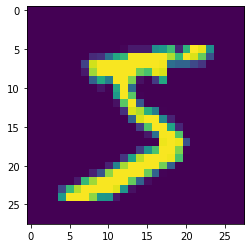

In [74]:
# Plotting and seeing the data
plt.imshow(train_x[0])
plt.show()

In [75]:
def compute_accuracy(y_true, y_pred):
    correct_classif = 0
    total = len(y_true)
    for i in range(total):
        if(y_true[i] == y_pred[i]):
            correct_classif += 1
    return correct_classif / total

In [76]:
criterions = ['gini', 'entropy']
accs = {}
for ct in tqdm(criterions):
    clf = DecisionTreeClassifier(criterion=ct)
    clf.fit(train_x_reshaped, train_y)
    preds = clf.predict(test_x_reshaped)
    accuracy = compute_accuracy(test_y, preds)
    accs[ct] = accuracy
print(f"Accuracy = {accs}")
if(accs['gini'] > accs['entropy']):
    final_criterion = 'gini'
else:
    final_criterion = 'entropy'

100%|██████████| 2/2 [00:50<00:00, 25.35s/it]

Accuracy = {'gini': 0.8794, 'entropy': 0.8873}


In [77]:
print(f"Final criterion = {final_criterion}")

Final criterion = entropy


In [78]:
bootstrapped_x = []
bootstrapped_y = []
n_samples = train_x_reshaped.shape[0]
num_bootstrap = 3

for i in range(num_bootstrap):
    sample_indexes = np.random.choice(n_samples, replace=True, size=n_samples)
    bootstrap_x_i = train_x_reshaped[sample_indexes, :]
    bootstrap_y_i = train_y[sample_indexes]
    bootstrapped_x.append(bootstrap_x_i)
    bootstrapped_y.append(bootstrap_y_i)

In [79]:
bootstrap_classifiers = []
for i in tqdm(range(num_bootstrap)):
    bootstrap_clf = DecisionTreeClassifier(criterion=final_criterion)
    bootstrap_clf.fit(bootstrapped_x[i], bootstrapped_y[i])
    bootstrap_classifiers.append(bootstrap_clf)

100%|██████████| 3/3 [00:46<00:00, 15.65s/it]


In [80]:
bootstrap_classifiers

[DecisionTreeClassifier(criterion='entropy'),
 DecisionTreeClassifier(criterion='entropy'),
 DecisionTreeClassifier(criterion='entropy')]

In [81]:
def majority_voting(preds):
    preds = np.array(preds)
    print(f"Shape of preds : {preds.shape}")
    final_prediction = []
    for i in range(preds.shape[1]):
        label, counts = np.unique(preds[:, i], return_counts=True)
        final_pred = label[np.argmax(counts)]
        final_prediction.append(final_pred)
    print(f"Length final_prediction : {len(final_prediction)}")
    return final_prediction

In [82]:
def predict(test_x, bootstrap_classifiers):
    preds = []
    for i in range(len(bootstrap_classifiers)):
        preds_i = bootstrap_classifiers[i].predict(test_x)
        preds.append(preds_i)
    final_preds = majority_voting(preds)
    return final_preds

In [83]:
final_predictions = predict(test_x_reshaped, bootstrap_classifiers)

Shape of preds : (3, 10000)
Length final_prediction : 10000


In [84]:
overall_accuracy = compute_accuracy(test_y, final_predictions)
print(f"\nOverall accuracy = {overall_accuracy}\n\n-------------\n")

# #Class-wise-accuracy
class_wise_accuracy = {}
for lab in labels:
    class_idxs = np.where(test_y == lab)[0]
    true_labs = test_y[class_idxs]
    pred_labs = np.array(final_predictions)[class_idxs]
    class_wise_accuracy[lab] = compute_accuracy(true_labs, pred_labs)
for lab in class_wise_accuracy.keys():
    print(f"Class-wise accuracy for class-{lab} : {class_wise_accuracy[lab]}")


Overall accuracy = 0.9122

-------------

Class-wise accuracy for class-0 : 0.9816326530612245
Class-wise accuracy for class-1 : 0.9885462555066079
Class-wise accuracy for class-2 : 0.9147286821705426
Class-wise accuracy for class-3 : 0.8960396039603961
Class-wise accuracy for class-4 : 0.905295315682281
Class-wise accuracy for class-5 : 0.875560538116592
Class-wise accuracy for class-6 : 0.907098121085595
Class-wise accuracy for class-7 : 0.9202334630350194
Class-wise accuracy for class-8 : 0.8429158110882957
Class-wise accuracy for class-9 : 0.8751238850346879
